In [190]:
from sympy import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sympy.plotting import plot3d
from sympy.solvers.ode.systems import dsolve_system
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.stats import * # Contains norm pdf and cdf
from sympy.core.sympify import sympify

from sympy.utilities.lambdify import lambdify

# 1-factor Gaussian HJM Model Clibration

In [191]:
# define symbolic variables
T, T0, T1, s, theta, k, sigma, r0, t, x, delta = symbols('T T_0 T_1 s theta kappa sigma r_0 t x delta', positive = True)

Ti, Tm1 = symbols('T_i T_{i-1}', positive = True)
beta, nu = symbols('beta nu', positive = True)
s, u, t = symbols('s u t', positive = True)

## Data

In [192]:
P = np.array([0.970873786407767, 0.933532486930545, 0.893332523378512, 0.850792879408107, 0.810278932769625, 0.771694221685358, 0.738463370033835, 0.706663511994101])
swap_rates = np.array([0.06, 0.08, 0.084889975550122, 0.089691000079435, 0.092085873002506, 0.093519632408032, 0.092999610296819, 0.092628040604575])
R = np.array([0.08, 0.089691000079435, 0.093519632408032, 0.092628040604575])
F = np.array([0.06, 0.08, 0.09, 0.10, 0.10, 0.10, 0.09, 0.09])
quotes = np.array([0.2/100, 0.8/100, 1.2/100, 1.6/100])
time = np.arange(0.5, 4.4, 0.5)

In [193]:
# given only the forward rates, we calculate the discount and the swap rates using the formula in the slides
data = pd.DataFrame([time, F, P, swap_rates]).T
data.columns = ['Maturity','Forward Rates', 'Discount', 'Swap Rates']
data.set_index('Maturity', inplace = True)
maturity = [1, 2, 3, 4]
maturity_prices = pd.DataFrame([maturity, quotes]).T
maturity_prices.columns = ['Maturity', 'Price(%)']
maturity_prices.set_index('Maturity', inplace = True)
maturity_prices*100

,Price(%)
Maturity,
1.0,0.2
2.0,0.8
3.0,1.2
4.0,1.6


In [194]:
data

,Forward Rates,Discount,Swap Rates
Maturity,,,
0.5,0.06,0.970874,0.060000
1.0,0.08,0.933532,0.080000
1.5,0.09,0.893333,0.084890
2.0,0.10,0.850793,0.089691
2.5,0.10,0.810279,0.092086
3.0,0.10,0.771694,0.093520
3.5,0.09,0.738463,0.093000
4.0,0.09,0.706664,0.092628


# Black's Formula for Caplets

- let $F_i = F(0, T_{i-1}, T_i)$

$Cpl(T_{i-1}, T_i) = \delta P(0,T_i)(F_i \Phi(d_{1,i}) - \kappa \Phi(d_{2,i}))$

$d_{1,i} = \frac{log(F_i/\kappa)+\frac{1}{2}\sigma^2T_{i-1}}{\sigma\sqrt{T_{i-1}}}$ and $d_{2,i} = d_{1,i}-\sigma \sqrt{T_{i-1}}$

In [195]:
# define symbols
Fi, P_i = symbols('Fi P_i', positive = True)
s1, s2, s3, s4 = symbols('sigma1 sigma2 sigma3 sigma4', positive = True)
Phi = Function('Phi')

In [196]:
# define the standard normal distribution function
# cdf = 0.5*(1+erf(x/sqrt(2)))
cdf = Phi(x)
# define d1 and d2
d1 = ((ln(Fi/k)+0.5*sigma**2*Tm1)/(sigma*sqrt(Tm1)))
d2 = d1 - sigma*sqrt(Tm1)

In [197]:
# define caplet black's equation
cpl = (delta*P_i*(Fi*cdf.subs(x,d1)-k*cdf.subs(x, d2))).subs(delta, 0.5)

In [198]:
# define the equation of the 4 caplite between first reset date 0.5 and last rest date 4
cpls = np.array([factor(cpl.subs([(P_i, P[i]), (Fi, F[i]), (Tm1, time[i-1])])) for i in range(1, 8)])
cpls = np.insert(cpls, 0, 0)

In [199]:
# combine caplets into 4 cap equations
i = 2
cpl_model = []
while i <= 8:
    cpl_model.append(sum(cpls[:i]))
    i += 2
cpl_model = np.array(cpl_model)
cpl_model = [cpl_model[i].subs(k, r) for i, r in zip(range(0, 4),R)]

## Implied Black's Volatility

- Now using the 4 Caplet equations and the market prices we solve for the volatility

- $min_{\hat{\sigma_i}}~(Cpl_{mkt_i} - Cpl_{model_i})^2$

In [82]:
Z = cpl_model-quotes

In [83]:
equations_list = []
for eq in Z:
    equations_list.append(str([eq][0]).replace('Phi', 'norm.cdf'))

In [84]:
# calibrate ATM cap prices
import math

def Z0(sigma):
    return eval(equations_list[0])
def Z1(sigma):
    return eval(equations_list[1])
def Z2(sigma):
    return eval(equations_list[2])
def Z3(sigma):
    return eval(equations_list[3])


In [85]:
# solve for the implied volatilities
import scipy
impl_vol = [scipy.optimize.fsolve(func, 1)[0] for func in [Z0, Z1, Z2, Z3]]

- Black Caplet Vega:

$\frac{\partial Cpl(T_{i-1},T_i)}{\partial \sigma} = \delta P(0,T_i)F_i\sqrt{T_{i-1}}\phi(d_{1,i})$

- Black Caplet Vegas:

$\frac{\partial C_n}{\partial \sigma} = \sum_{i=1}^{n}\frac{\partial Cpl(T_{i-1}, T_i)}{\partial \sigma}$

In [86]:
phi = Function('phi')
# pdf = 1/sqrt(2*pi)*exp(-1/2*x**2).subs(x, d1) # The standard normal distribution has probability density (mean 0 and std 1)
pdf = phi(x)
# 0.5 below represents delta
cpl_vega = np.array([(delta*P_i*Fi*sqrt(Tm1)*pdf.subs(x, d1)).subs([(P_i, P[i]),(Tm1, time[i-1]), (Fi, F[i]), (delta, 0.5)]).evalf() for i in range(1, 8)])
cpl_vega = np.insert(cpl_vega, 0, 0)

In [87]:
# combine caplets into 4 cap equations
i = 2
cpl_vegas = []
while i <= 8:
    cpl_vegas.append(sum(cpl_vega[:i]))
    i += 2
cpl_vegas = np.array(cpl_vegas)
cpl_vegas = np.array([cpl_vegas[i].subs([(k, r), (sigma, s)]) for i, r, s in zip(range(0, 4),R, impl_vol)])

for i in range(len(cpl_vegas)):
    cpl_vegas[i] = eval(str(cpl_vegas[i]).replace('phi', 'norm.pdf'))
cpl_vegas = cpl_vegas.astype(float)

In [88]:
table = maturity_prices*100
table.index = table.index.astype(int)

In [127]:
model_prices = []
for i in range(4):
    cplt_form = cpl_model[i].subs([(beta, 1.52102858), (nu, 0.02934939)])
    model_prices.append(eval(str(cplt_form).replace('Phi', 'norm.cdf').replace('sqrt', 'np.sqrt')))
model_prices = np.array(model_prices)*100

## Final Step - Weighted Least Squares Calibration

- Volatility Specification (we need to calibrate $\beta~\&~\nu $ )

$\sigma(t,T) = e^{-\beta(T-t)}\nu$

- Bond return volatility

$\nu(t,T)=\int_{t}^{T} \sigma(t,u) \,du$

- Bond put price under Gaussian HJM model is:

$Cpl(T_{i-1}, T_i) = (1+\delta \kappa)(\frac{1}{1+\delta \kappa}P(0,T_{i-1})\Phi(-d_2(i))-P(0,T_i)\Phi(-d_1(i)))$

$d_{1,2}(i) = \frac{log(\frac{P(0,T_i)}{P(0,T_{i-1})}(1+\delta \kappa))\pm\frac{1}{2}\int_{0}^{T_{i-1}} ||\nu(s, T_{i-1}) - \nu(s, T_{i})||^{2} \,ds}{\sqrt{\int_{0}^{T_{i-1}} ||\nu(s, T_{i-1}) - \nu(s, T_{i})||^{2} \,ds}}$

$\int_{0}^{T_{i-1}} ||\nu(s, T_{i-1}) - \nu(s, T_{i})||^{2} \,ds$

In [93]:
# Volatilities
volatility = exp(-beta*(u-t))*nu
v0 = -integrate(volatility, (u, s, Tm1)).subs(t, s)
v1 = -integrate(volatility, (u, s, Ti)).subs(t, s)

v01 = factor(integrate((v0-v1)**2, (s, 0, Tm1)))

In [94]:
Pm1 = symbols('P_{i-1}', positive = True)

In [136]:
#cdf = 0.5*(1+erf(x/sqrt(2)))
d1 = (ln(P_i/Pm1*(1+delta*k))+0.5*v01)/(sqrt(v01))
d2 = (ln(P_i/Pm1*(1+delta*k))-0.5*v01)/(sqrt(v01))

cpl = simplify((1+delta*k)*(1/(1+delta*k)*Pm1*cdf.subs(x, -d2)-P_i*cdf.subs(x,-d1)))

In [137]:
cpls = np.array([cpl.subs([(P_i, P[i]), (Pm1, P[i-1]), (delta, 0.5), (Ti, time[i]), (Tm1, time[i-1])]) for i in range(1, 8)])
cpls = np.insert(cpls, 0, 0)

In [138]:
# combine caplets into 4 cap equations
i = 2
cpl_model = []
while i <= 8:
    cpl_model.append(sum(cpls[:i]))
    i += 2
cpl_model = np.array(cpl_model)
cpl_model = np.array([cpl_model[i].subs(k, r) for i, r in zip(range(0, 4),R)])

In [71]:
# use expand to remove the square, since it will make problems in the minimization step
Z = expand(sum(((cpl_model - quotes)**2/(cpl_vegas)**2)))

In [55]:
# using numpy
replace_str = ['Phi', 'Abs', 'sqrt', 'log', 'exp']
replacement = ['norm.cdf', 'np.abs', 'np.sqrt', 'np.log', 'np.exp']

for r, re in zip(replace_str, replacement):
    Z = str([Z][0]).replace(r, re)

In [56]:
def Cal(x):
    beta = x[0]
    nu = x[1]
    return eval(Z)

In [38]:
# minimize uisng Nelder-Mead algorithm
minimize(Cal, [0.01, 0.01], method='Nelder-Mead', tol = 1e-25) #using low tolerance and mpmath we get high precision

 final_simplex: (array([[1.52102858, 0.02934939],
       [1.52102858, 0.02934939],
       [1.52102858, 0.02934939]]), array([0.00010328, 0.00010328, 0.00010328]))
           fun: 0.00010328201851494967
       message: 'Optimization terminated successfully.'
          nfev: 298
           nit: 131
        status: 0
       success: True
             x: array([1.52102858, 0.02934939])

In [57]:
solvers = ['Nelder-Mead', 'CG', 'BFGS', 'L-BFGS-B', 'TNC', 'SLSQP', 'trust-constr']

In [58]:
solvers_list = []
beta_list = []
nu_list = []
for solver in solvers:
    solution = minimize(Cal, [0.01, 0.01], method=solver)
    solvers_list.append(solution.fun)
    beta_list.append(solution.x[0])
    nu_list.append(solution.x[1])

<string>:1: RuntimeWarning: invalid value encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in sqrt


In [60]:
df = pd.DataFrame([solvers, solvers_list, beta_list, nu_list]).T
df.columns = ['Solver', 'Objective Function', r'$\beta$', r'$\nu$']
df.sort_values('Objective Function')

,Solver,Objective Function,$\beta$,$\nu$
1,BFGS,0.000103,1.4933,0.028975
2,L-BFGS-B,0.000104,1.478899,0.028762
4,SLSQP,0.000104,1.57261,0.030021
0,CG,0.000106,1.408858,0.027875
5,trust-constr,0.000106,1.407702,0.027847
3,TNC,0.001459,0.612322,0.016206


In [139]:
table['ATM Strike'] = R*100
table['Black\'s implied Volatilties'] = impl_vol
table['Caplet Vegas'] = cpl_vegas
table['Model Prices'] = model_prices

In [177]:
table.columns = ['Market Quote', 'ATM Strike', 'Black\'s implied Volatilties', 'Caplet Vegas',
       'Model Prices']

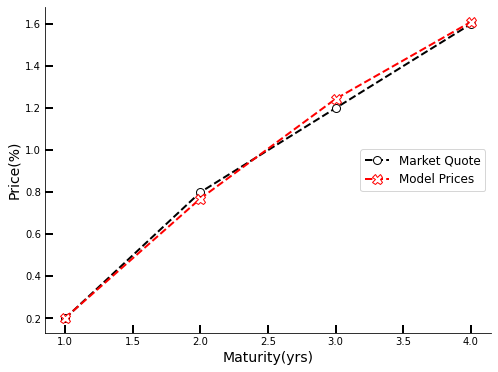

In [183]:
fig, ax = plt.subplots(figsize = [8, 6]);
plt.plot(table.index, 'Market Quote', data = table, color = 'k', lw = 2, marker ='o', markersize=8, markerfacecolor = 'white', markeredgecolor = 'k', linestyle = '--')
plt.plot(table.index, 'Model Prices', data = table, color = 'r', lw = 2, marker ='X', markersize=10, markerfacecolor = 'white', markeredgecolor = 'red', linestyle = '--')

ax.set_xlabel('Maturity(yrs)', size = 14)
ax.set_ylabel('Price(%)', size = 14)
ax.spines[["top", 'right']].set_visible(False)
ax.tick_params(direction = 'in', length=8, width=2, colors='k',
               grid_color='k', grid_alpha=.1)
plt.legend(fontsize = 12, loc = 'center right');

In [200]:
Z = cpl_model-model_prices/100

In [201]:
equations_list = []
for eq in Z:
    equations_list.append(str([eq][0]).replace('Phi', 'norm.cdf'))

In [202]:
# calibrate ATM cap prices
import math

def Z0(sigma):
    return eval(equations_list[0])
def Z1(sigma):
    return eval(equations_list[1])
def Z2(sigma):
    return eval(equations_list[2])
def Z3(sigma):
    return eval(equations_list[3])


In [203]:
# solve for the implied volatilities
import scipy
impl_vol_model = [scipy.optimize.fsolve(func, 1)[0] for func in [Z0, Z1, Z2, Z3]]

In [207]:
table['Model IV'] = np.array(impl_vol_model)

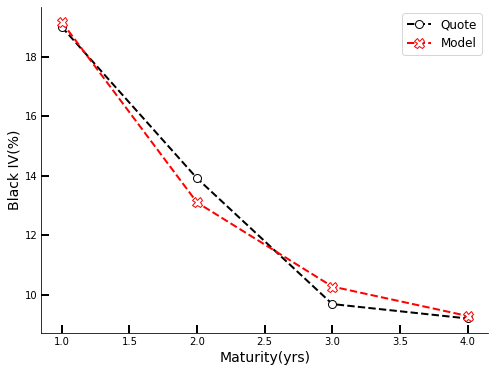

In [212]:
fig, ax = plt.subplots(figsize = [8, 6]);
plt.plot(table.index, 'Black\'s implied Volatilties', data = table*100, color = 'k', lw = 2, marker ='o', markersize=8, markerfacecolor = 'white', markeredgecolor = 'k', linestyle = '--')
plt.plot(table.index, 'Model IV', data = table*100, color = 'r', lw = 2, marker ='X', markersize=10, markerfacecolor = 'white', markeredgecolor = 'red', linestyle = '--')

ax.set_xlabel('Maturity(yrs)', size = 14)
ax.set_ylabel('Black IV(%)', size = 14)
ax.spines[["top", 'right']].set_visible(False)
ax.tick_params(direction = 'in', length=8, width=2, colors='k',
               grid_color='k', grid_alpha=.1)
plt.legend(fontsize = 12, labels = ['Quote', 'Model'],loc = 'upper right');